In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob


In [40]:
def compute_skewness(x):
    
    n = len(x)
    third_moment = np.sum((x - np.mean(x))**3) / n
    s_3 = np.std(x, ddof = 1) ** 3
    return third_moment/s_3

In [41]:
def compute_kurtosis(x):
    
    n = len(x)
    fourth_moment = np.sum((x - np.mean(x))**4) / n
    s_4 = np.std(x, ddof = 1) ** 4
    return fourth_moment / s_4 - 3

In [42]:
test = 2
files = glob.glob(f"nasa_bearing_dataset/bear**{test}*/**{test}*/*",recursive=True)


In [43]:
file_al = []
for file in files:
    file_al.append(glob.glob(os.path.join(file,'*'),recursive=True))


In [44]:
# bearings = {}

# bearings[0] = []
# bearings[1] = []
# bearings[2] = []
# bearings[3] = []
# # bearings[4] = []
# # bearings[5] = []
# # bearings[6] = []
# # bearings[7] = []


# for root, dirs, files in os.walk("nasa_bearing_dataset/bearing_2nd_test/2nd_test/", topdown=False):
#     for file_name in files:
#         path = os.path.join(root, file_name)
#         # print(file_name[:-3])
#         dataset=pd.read_csv(path, sep='\t',header=None)

#         for column in dataset.columns:
#             dataset[column].name = file_name[:-3]
#             bearings[column].append(dataset[column])


In [45]:
len(bearings)

4

In [46]:
len(bearings[0])

984

In [47]:
bearings_feature = {}

In [48]:
def to_feature(df):
    data = pd.DataFrame()
    data['max'] = df[df.columns[1:]].max(axis = 1)
    data['min'] = df[df.columns[1:]].min(axis = 1)
    data['mean'] = df[df.columns[1:]].mean(axis = 1)
    data['std'] = df[df.columns[1:]].std(ddof=1,axis = 1)
    data['rms'] = df[df.columns[1:]].apply(lambda x: np.sqrt(np.mean(x**2)), axis=1)
    data['skewness'] = df[df.columns[1:]].apply(lambda x: compute_skewness(x), axis=1)
    data['kurtosis'] = df[df.columns[1:]].apply(lambda x: compute_kurtosis(x), axis=1)
    data['crest_factor'] = data['max'] / data['rms']
    data['form_factor'] = data['rms'] / data['mean']
    return data

In [49]:
prueba = to_feature(pd.DataFrame(bearings[0]))

In [50]:
# test = 2
# for bearing in bearings:
#     pd.DataFrame(bearings[bearing]).to_csv(f'nasa_bearing_dataset/test{test}_bearing_{bearing}_time.csv')
#     to_feature(pd.DataFrame(bearings[bearing])).to_csv(f'nasa_bearing_dataset/test{test}_bearing_{bearing}_feature.csv')


In [51]:
def fft_freq(df_time:pd.DataFrame):
    df_freq = df_time.copy()
    filter_vibr = [str(i) for i in range(len(df[0].columns))]
    df_freq = df_freq.drop(columns=filter_vibr, axis = 1)
    
    freq_data = []
    for i,row in df_time.iterrows():
        y = np.array(df_time.loc[i,filter_vibr].tolist())
        # vibration_data = data['Vibration'].values
        vibration_data = y
        # Time parameters
        sampling_rate =  20000 # Hz, example sampling rate
        n = len(vibration_data)
        time = np.arange(n) / sampling_rate

        # Perform FFT
        freq_domain = np.fft.fft(vibration_data)
        freq = np.fft.fftfreq(n, d=1/sampling_rate)

        x_freq = freq[:n//2]
        y_freq = np.abs(freq_domain)[:n//2] * 1/n

        freq_data.append(y_freq)

    df_freq = pd.DataFrame(data = freq_data)
    # df_freq = pd.concat([df_freq,pd.DataFrame(freq_data)],axis=0)
    # columns = [str(x) for x in df_freq.columns]
    # df_freq.columns = columns
    df_freq.index = df_time.index
    return df_freq


In [52]:
df = []
format_str = '%Y.%m.%d.%H.%M'
for i in range(4):
    df.append(pd.read_csv(f'nasa_bearing_dataset/test2_bearing_{i}_time.csv', index_col= 'Unnamed: 0'))
    df[i].index = pd.to_datetime(df[i].index, format= format_str)

In [53]:
df_f = []
format_str = '%Y.%m.%d.%H.%M'
for i in range(4):
    df_f.append(pd.read_csv(f'nasa_bearing_dataset/test2_bearing_{i}_feature.csv', index_col= 'Unnamed: 0'))
    df_f[i].index = pd.to_datetime(df_f[i].index, format= format_str)

In [54]:
df_f[0].columns

Index(['max', 'min', 'mean', 'std', 'rms', 'skewness', 'kurtosis',
       'crest_factor', 'form_factor'],
      dtype='object')

In [55]:
len(df[0].columns)

20480

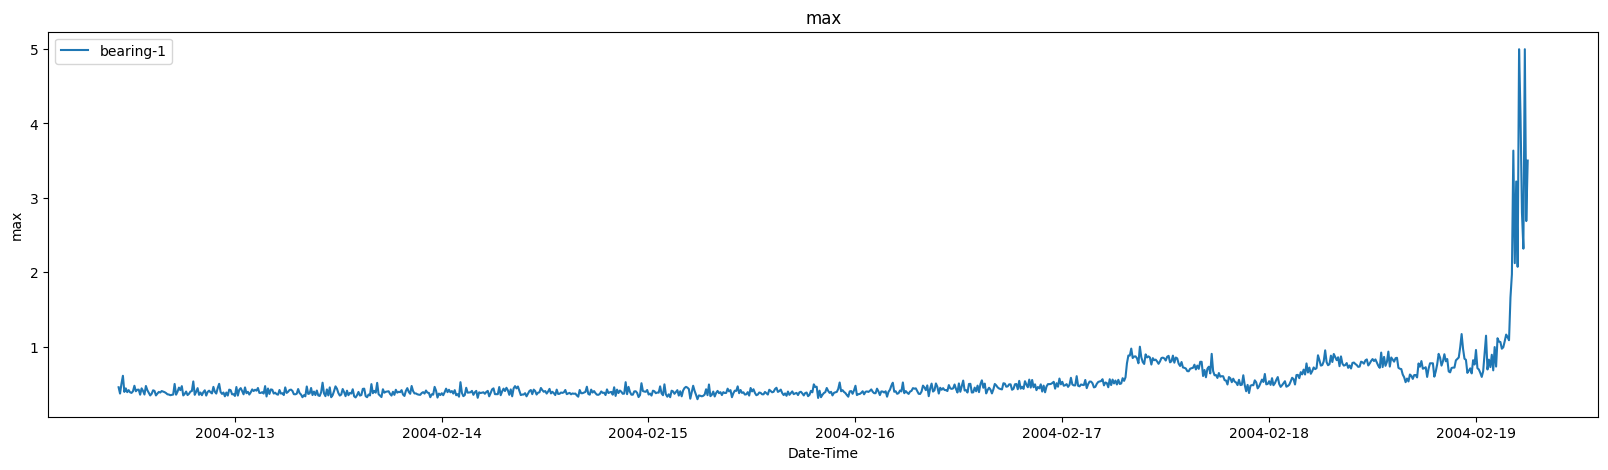

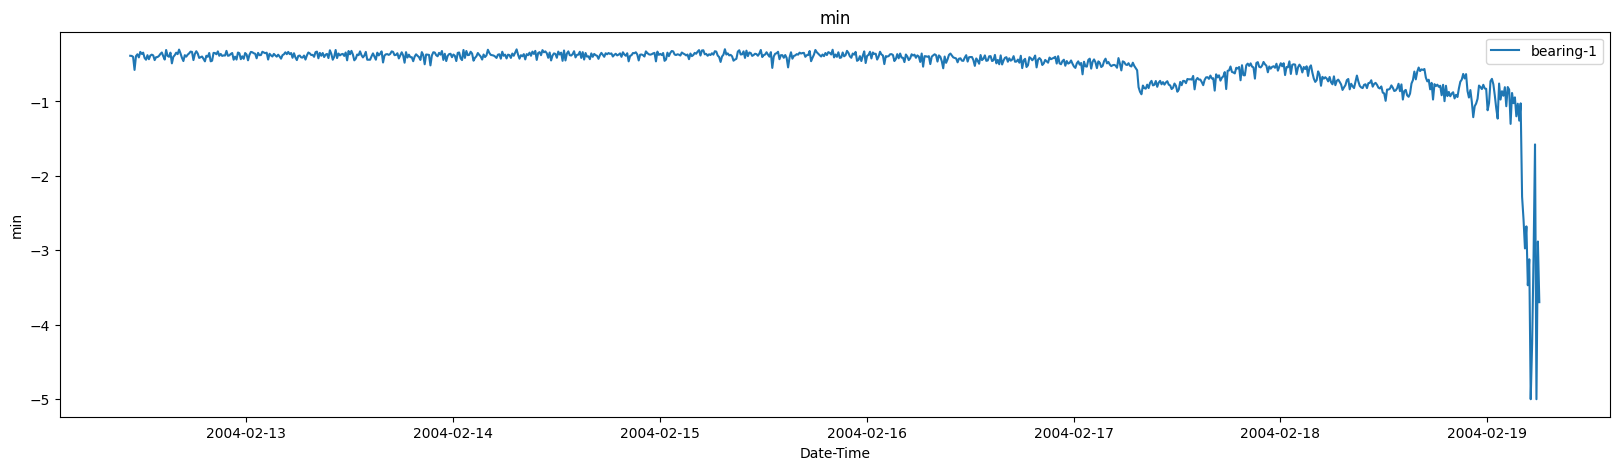

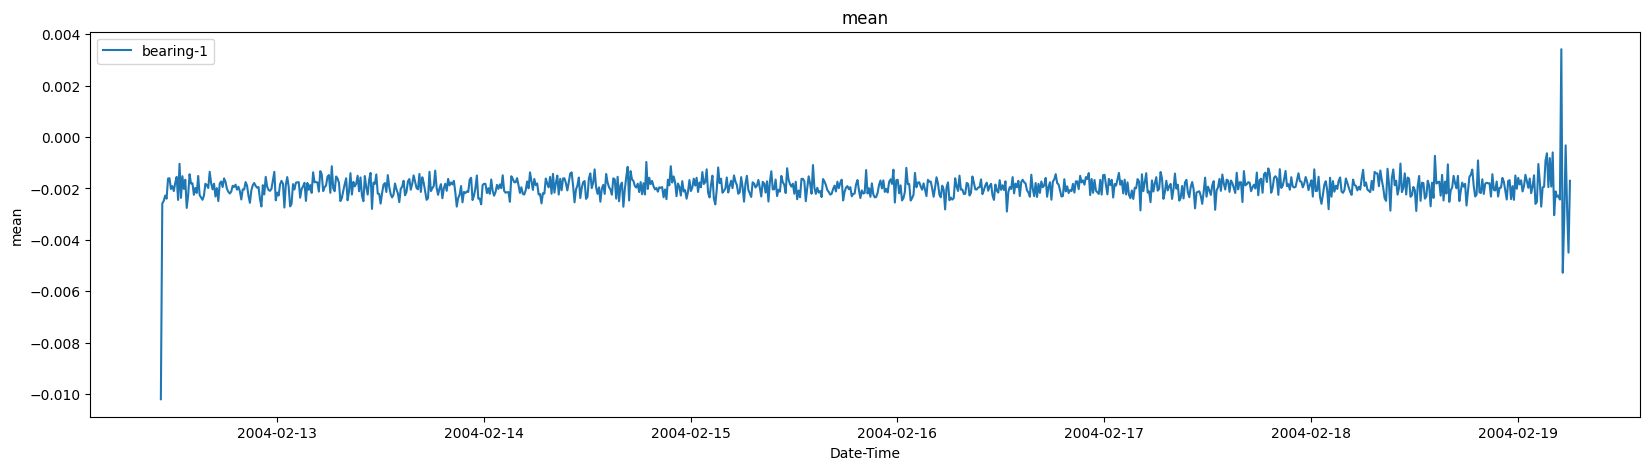

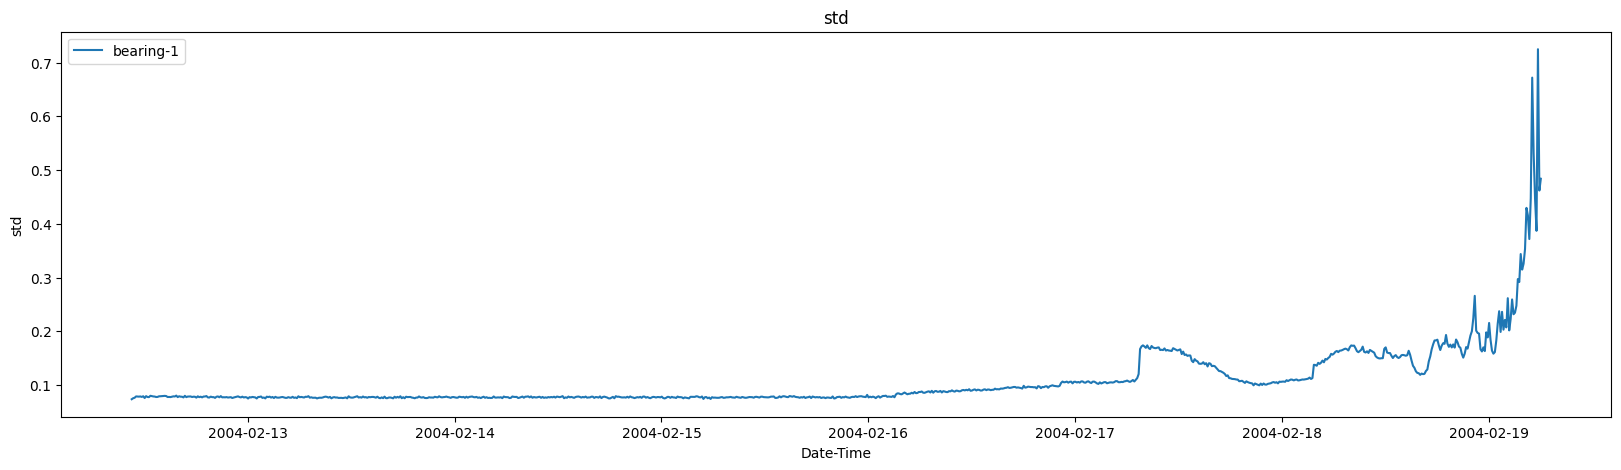

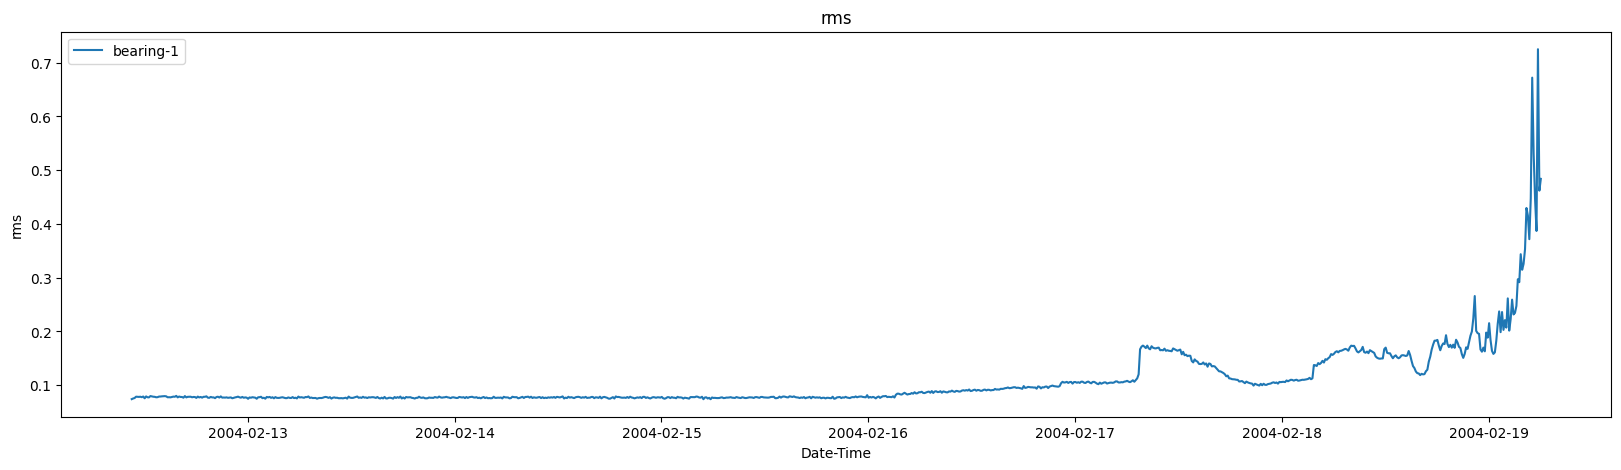

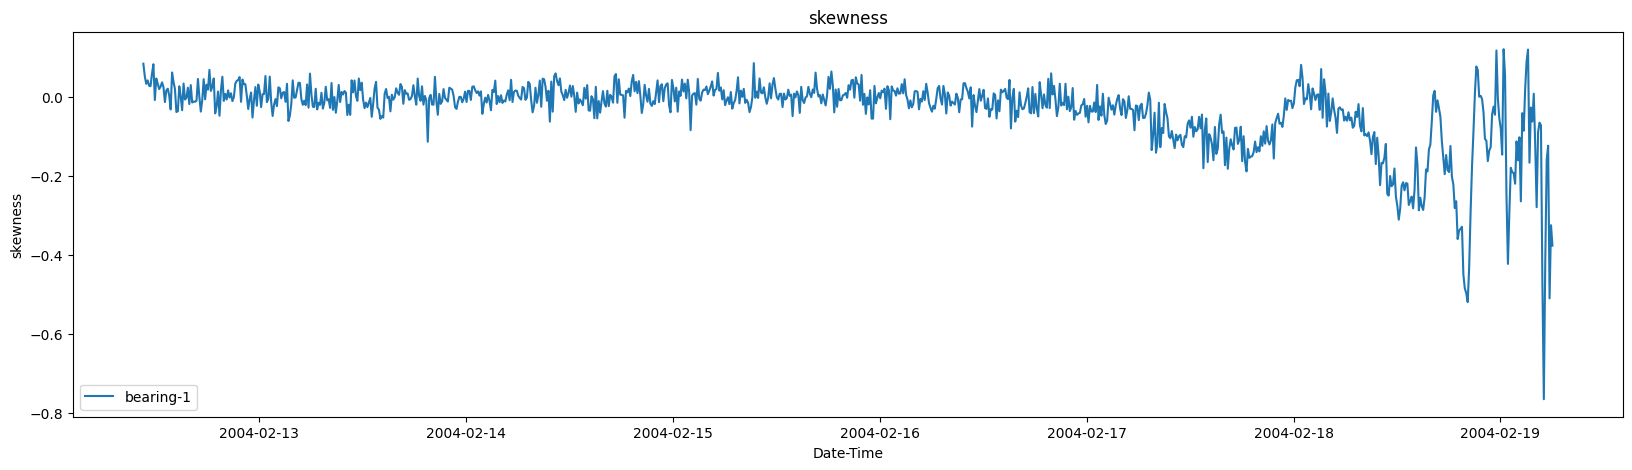

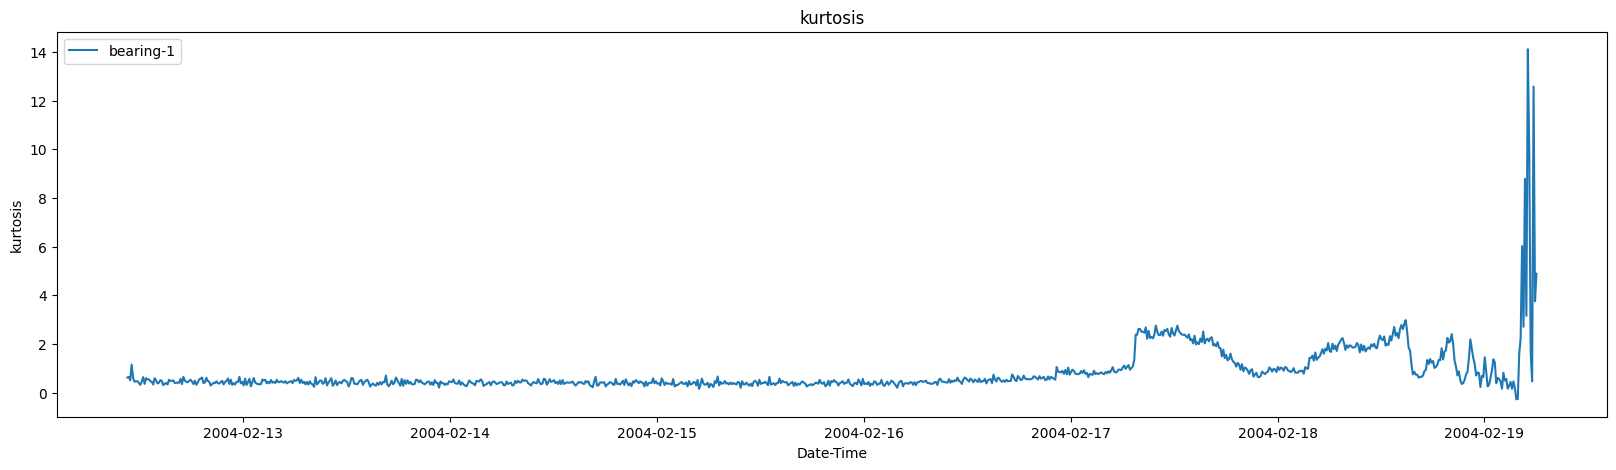

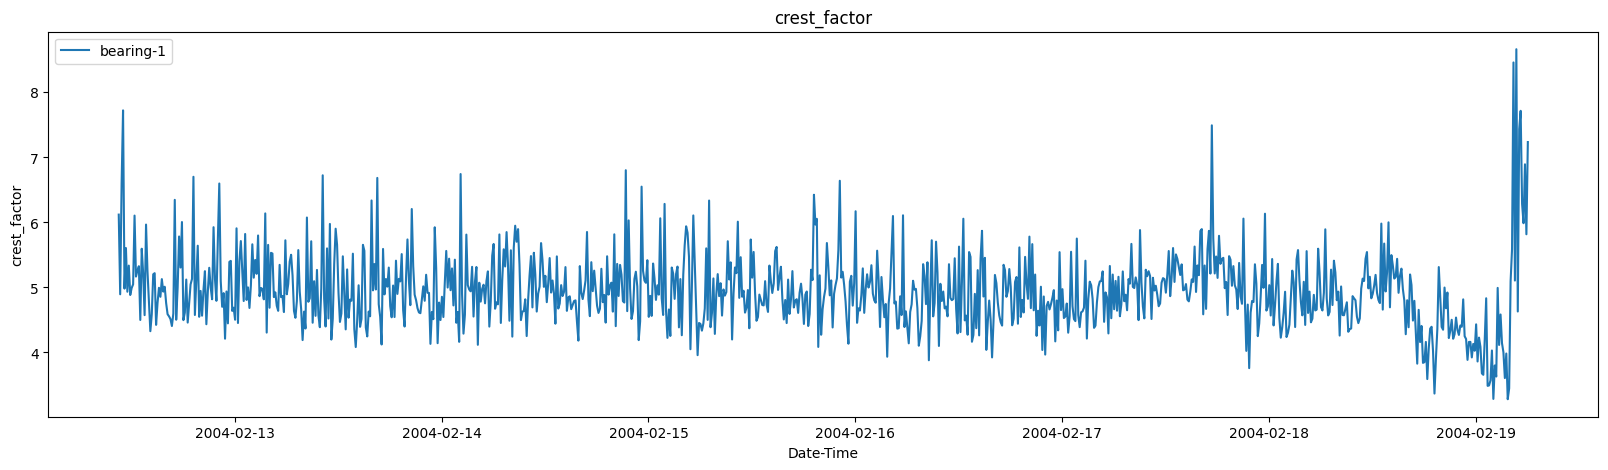

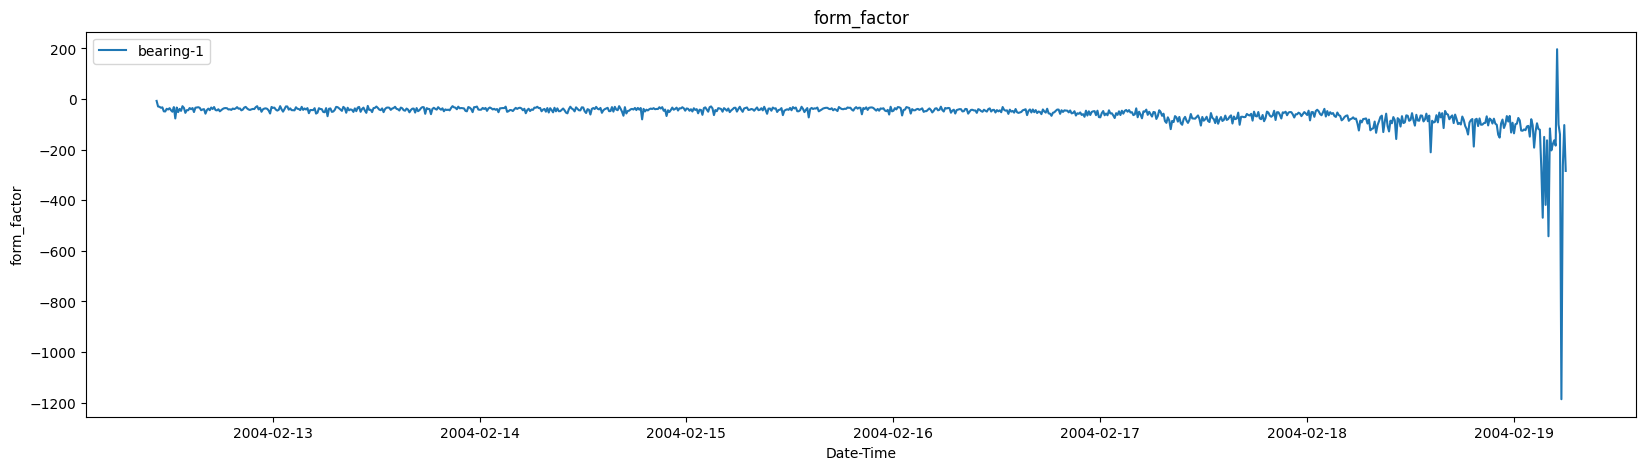

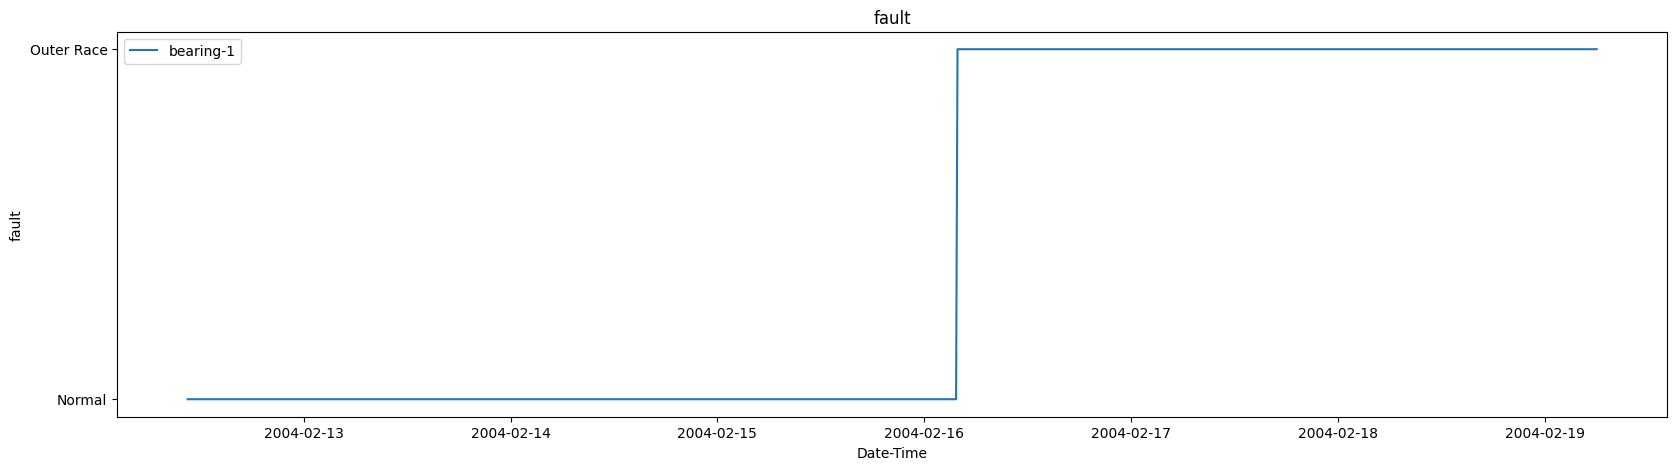

In [82]:
for col in (df_f[0].columns):  
    
        plt.figure(figsize=(20, 5))
        plt.plot(df_f[0].index,df_f[0][col])
        # plt.plot(df_f[0].index,df_f[1][col])
        # plt.plot(df_f[0].index,df_f[2][col])
        # plt.plot(df_f[0].index,df_f[3][col])

        plt.legend(['bearing-1','bearing-2','bearing-3','bearing-4'])

        plt.xlabel("Date-Time")
        plt.ylabel(col)
        plt.title(col)
        plt.show()

In [57]:
# Load your vibration data from a CSV file
# Assume the CSV file has a single column of vibration data with a header
# data = pd.read_csv('vibration_data.csv')
def to_fft(y, sample_rate):
    # vibration_data = data['Vibration'].values
    vibration_data = y
    # Time parameters
    sampling_rate = sample_rate  # Hz, example sampling rate
    n = len(vibration_data)
    time = np.arange(n) / sampling_rate

    # Perform FFT
    freq_domain = np.fft.fft(vibration_data)
    freq = np.fft.fftfreq(n, d=1/sampling_rate)

    x_freq = freq[:n//2]
    y_freq = np.abs(freq_domain)[:n//2] * 1/n


    # Plot the results
    plt.figure(figsize=(20,6))

    # Time domain plot
    plt.subplot(2, 1, 1)
    plt.plot(time, vibration_data)
    plt.title('Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Vibration Amplitude')

    # Frequency domain plot
    plt.subplot(2, 1, 2)
    plt.plot(freq[:n//2], np.abs(freq_domain)[:n//2] * 1/n)
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

    plt.tight_layout()
    plt.show()


In [58]:
df[0].shape

(984, 20480)

In [59]:
min(df[0].index)

Timestamp('2004-02-12 10:32:00')

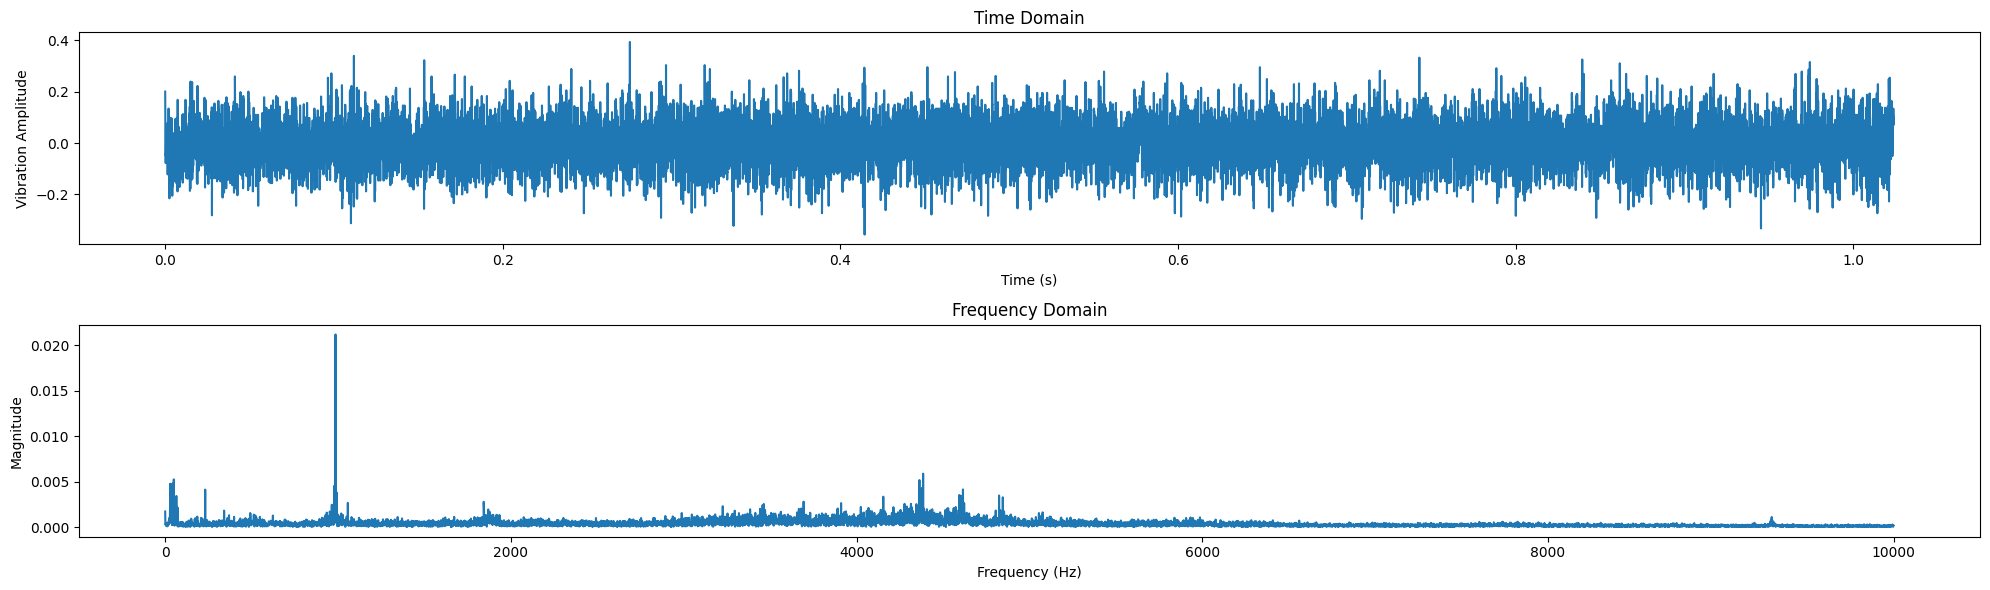

Timestamp('2004-02-16 03:52:00')

In [60]:
num = 536
to_fft(df[0].iloc[num,:], 20000)
df[0].iloc[num,:].name

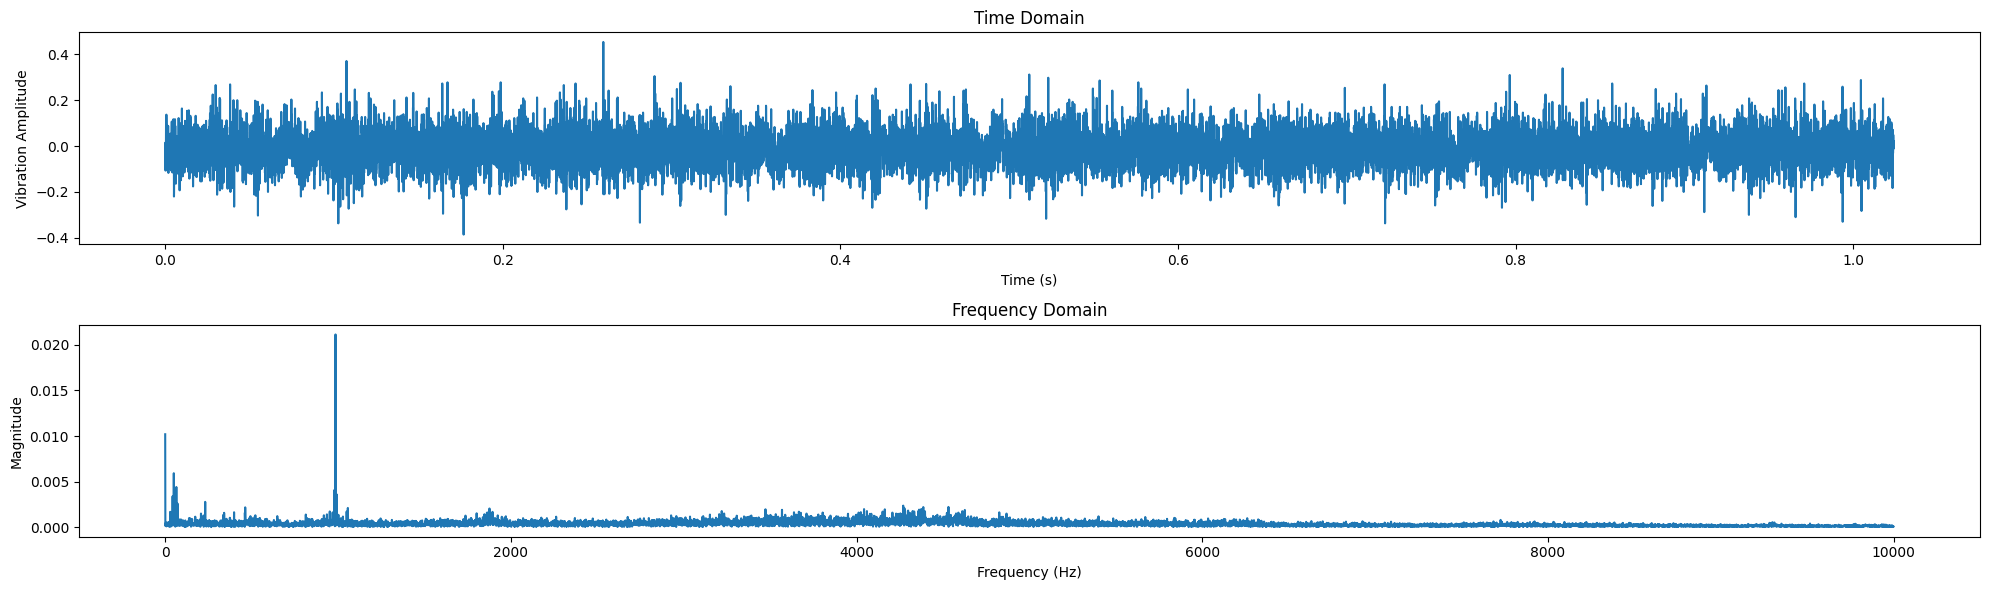

Timestamp('2004-02-12 10:32:00')

In [61]:
num = 0
to_fft(df[0].iloc[num,:], 20000)
df[0].iloc[num,:].name

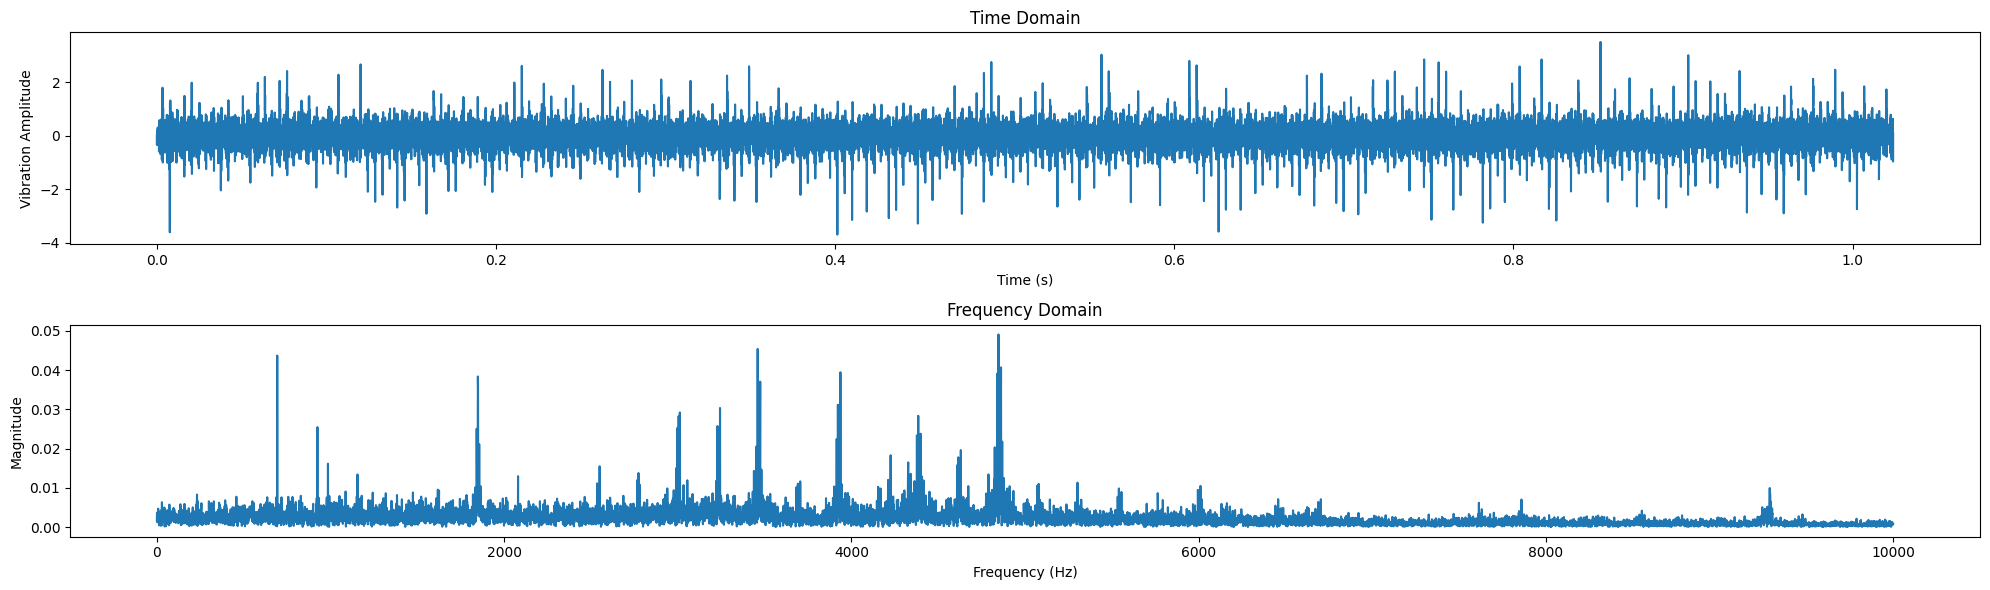

Timestamp('2004-02-19 06:02:00')

In [62]:
num = 981
to_fft(df[0].iloc[num,:], 20000)
df[0].iloc[num,:].name

In [63]:
df[0].drop(index=['2004-02-19 06:22:00','2004-02-19 06:12:00'], inplace = True)

In [67]:
df[0].head()

,0,1,2,3,4,5,6,7,8,9,...,20470,20471,20472,20473,20474,20475,20476,20477,20478,20479
2004-02-12 10:32:00,-0.049,-0.042,0.015,-0.051,-0.107,-0.078,-0.020,-0.046,-0.063,0.068,...,0.071,0.012,-0.032,-0.029,-0.017,0.049,0.037,-0.012,-0.012,0.020
2004-02-12 10:42:00,-0.088,0.022,-0.015,-0.083,-0.056,0.117,0.063,-0.056,-0.007,-0.051,...,-0.024,-0.059,-0.005,0.049,0.024,-0.059,0.010,0.120,0.098,0.010
2004-02-12 10:52:00,0.112,0.049,-0.027,-0.110,0.007,0.122,0.134,-0.015,-0.168,-0.061,...,-0.037,-0.020,0.002,-0.002,-0.049,-0.125,-0.024,-0.068,-0.105,-0.010
2004-02-12 11:02:00,0.017,-0.085,-0.122,-0.039,-0.063,-0.127,-0.022,-0.005,0.044,-0.012,...,0.046,-0.144,-0.222,-0.059,-0.027,-0.088,-0.098,-0.012,-0.049,-0.051
2004-02-12 11:12:00,-0.066,0.051,0.020,0.034,-0.081,0.015,0.112,0.051,0.066,0.032,...,0.061,0.149,0.090,-0.015,0.051,0.081,0.073,-0.022,-0.020,0.076


In [64]:
df_f[0].drop(index=['2004-02-19 06:22:00','2004-02-19 06:12:00'], inplace = True)

In [69]:
df_f[0].head()

,max,min,mean,std,rms,skewness,kurtosis,crest_factor,form_factor
2004-02-12 10:32:00,0.454,-0.386,-0.010194,0.073478,0.074180,0.083917,0.628317,6.120246,-7.276759
2004-02-12 10:42:00,0.369,-0.388,-0.002581,0.075339,0.075382,0.052047,0.648122,4.895081,-29.208250
2004-02-12 10:52:00,0.503,-0.400,-0.002490,0.076189,0.076228,0.032865,0.513496,6.598658,-30.618731
2004-02-12 11:02:00,0.608,-0.576,-0.002278,0.078694,0.078726,0.041517,1.157370,7.723037,-34.565835
2004-02-12 11:12:00,0.391,-0.391,-0.002401,0.078440,0.078475,0.028130,0.602855,4.982488,-32.687613


In [70]:
df_freq[0].drop(index=['2004-02-19 06:22:00','2004-02-19 06:12:00'], inplace = True)

KeyError: "['2004-02-19 06:22:00', '2004-02-19 06:12:00'] not found in axis"

In [71]:
df_freq[0].head()

,0,1,2,3,4,5,6,7,8,9,...,10231,10232,10233,10234,10235,10236,10237,10238,10239,fault
2004-02-12 10:32:00,0.010196,0.000138,0.000402,0.000447,0.000449,0.000363,0.000514,0.000086,0.000415,0.000133,...,0.000176,0.000014,0.000063,0.000094,0.000113,0.000063,0.000092,0.000082,0.000068,Normal
2004-02-12 10:42:00,0.002585,0.000362,0.000223,0.000339,0.000054,0.000424,0.000252,0.000099,0.000097,0.000068,...,0.000099,0.000097,0.000072,0.000218,0.000111,0.000052,0.000030,0.000307,0.000107,Normal
2004-02-12 10:52:00,0.002484,0.000119,0.000387,0.000168,0.000156,0.000288,0.000440,0.000172,0.000332,0.000333,...,0.000242,0.000064,0.000051,0.000107,0.000094,0.000064,0.000109,0.000065,0.000228,Normal
2004-02-12 11:02:00,0.002277,0.000317,0.000401,0.000278,0.000095,0.000298,0.000193,0.000402,0.000317,0.000454,...,0.000065,0.000254,0.000223,0.000098,0.000328,0.000155,0.000117,0.000121,0.000194,Normal
2004-02-12 11:12:00,0.002404,0.000243,0.000249,0.000137,0.000421,0.000081,0.000614,0.000295,0.000125,0.000500,...,0.000006,0.000231,0.000096,0.000165,0.000060,0.000249,0.000121,0.000070,0.000186,Normal


In [75]:
df[0].isna().sum().sum()

np.int64(0)

In [76]:
df_f[0].isna().sum().sum()

np.int64(0)

In [77]:
df_freq[0].isna().sum().sum()

np.int64(0)

In [ ]:
freq_df = fft_freq(df[0])

In [ ]:
freq_df.shape

(982, 10240)

In [ ]:
df_freq = []
test = 2
for i in range(4):
    df_freq.append(fft_freq(df[i]))
    df_freq[i].to_csv(f'nasa_bearing_dataset/test{test}_bearing_{i}_freq.csv')

In [ ]:
test = 2

In [78]:
df[0].loc['2004-02-12 10:32:00':'2004-02-16 03:42:00','fault'] = 'Normal'
df[0].loc['2004-02-16 03:52:00':'2004-02-19 06:02:00','fault'] = 'Outer Race'
df[0].to_csv(f'nasa_bearing_dataset/target_test{test}_bearing_{0}_time.csv')

In [79]:
df_f[0].loc['2004-02-12 10:32:00':'2004-02-16 03:42:00','fault'] = 'Normal'
df_f[0].loc['2004-02-16 03:52:00':'2004-02-19 06:02:00','fault'] = 'Outer Race'
df_f[0].to_csv(f'nasa_bearing_dataset/target_test{test}_bearing_{0}_feature.csv')

In [80]:
df_freq[0].loc['2004-02-12 10:32:00':'2004-02-16 03:42:00','fault'] = 'Normal'
df_freq[0].loc['2004-02-16 03:52:00':'2004-02-19 06:02:00','fault'] = 'Outer Race'
df_freq[0].to_csv(f'nasa_bearing_dataset/target_test{test}_bearing_{0}_freq.csv')